In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import importlib
import subprocess

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions

import ATARI.utils.io.hdf5 as h5io

from copy import copy
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.PiTFAll import fnorm


In [2]:
%matplotlib widget

In [3]:
def plot_trans(exp_pw, T1):
    
    fig = figure()
    # plot(exp_pw.E, exp_pw.theo_trans, ms=1, color='g')
    # plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, 'r', alpha=0.2, lw=3)
    # plot(sammyOUT_bayes.pw.E, sammyOUT_bayes.pw.theo_trans_bayes, 'b-')
    plot(T1.E, T1.theo_trans, 'b')
    errorbar(exp_pw.E, exp_pw.exp, yerr=exp_pw.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    ylim([-.1, 1])
    return fig


def plot_trans_cap(trans, cap, T1=None,C1=None, plot_true=False):

    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)
    axes[0].errorbar(trans.E, trans.exp, yerr=trans.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    
    axes[1].errorbar(cap.E, cap.exp, yerr=cap.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    
    if C1 is not None and T1 is not None:
        axes[0].plot(T1.E, T1.theo_trans, 'b')
        axes[1].plot(C1.E, C1.theo_xs, 'b')
        if plot_true:
            axes[0].plot(trans.E, trans.true, 'g')
            axes[1].plot(cap.E, cap.true, 'g')
    else:
        axes[0].plot(trans.E, trans.true, 'g')
        axes[1].plot(cap.E, cap.true, 'g')
        

    axes[0].set_ylabel("T")
    axes[1].set_yscale('log')
    axes[1].set_ylabel(r'$\sigma_{\gamma}$ (barns)')
    axes[1].set_ylim(bottom=5e-4)

    # legend()
    fig.supxlabel('Energy (eV)')
    fig.tight_layout()
    return fig


In [4]:
### Setup physics
spin_groups = [ (3.0,1,0) ]
res_par_avg = make_res_par_avg(J_ID=1,
                               D_avg = 8.79, 
                            Gn_avg= 0.658, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 1000, 
                            print = False)

ac = 0.81271; M = 180.948030; m = 1; I = 3.5; i = 0.5; l_max = 1 
average_parameters = {'3.0':res_par_avg}
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   



In [5]:
sammy_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'
shell = 'zsh'
template = "dop_1sg.inp"
reactions = ["elastic", "capture"]

case_file = "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/data_1.hdf5"

energy_range = [200,250]
temperature = 300
target_thickness = 0.005


In [6]:
#%% pull estimates & calculate residuals

# result_dict = {}
# res_dict = {}
# time_dict = {}
# # for gn in ["Gnavg", "Gnmin"]:
# for gn in ["Gn10min", "Gn1000min"]:
#     basepath = f"/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/2spingroups/{gn}"

#     for thresh in ["1en1", "1en2", "1en3", "1en4", "1en5"]:
#         for iE in [50,75,100]:
#             case = f"{gn}_{thresh}_iE{iE}"
        
#             true_par_list = []
#             est_par_list = []
#             time_list = []
#             for isample in range(500):
#                 true_par = h5io.read_par(case_file, isample, 'true') 

#                 try:
#                     step1df = pd.read_csv(os.path.join(basepath, f"par_i{isample}_iE{iE}.csv"))
#                     time_step1 = step1df["time"]

#                     par_df = pd.read_csv(os.path.join(basepath, f"step2_{thresh}", f"par_i{isample}_iE{iE}.csv"))
#                     time_step2 = par_df["time"]
#                     est_par = par_df[["E", "Gg", "Gn1", "J_ID"]]
#                     # est_par = sammy_functions.fill_sammy_ladder(est_par, Ta_pair)
#                     true_par_list.append(true_par)
#                     est_par_list.append(est_par)
#                     time_list.append(time_step1+time_step2)

#                 except:
#                     print(f"job_failed: {gn}, {thresh}, {iE}, {isample}")


#             Rdict = fnorm.build_residual_matrix_dict(est_par_list, true_par_list,
#                                     sammy_exe, shell,
#                                     Ta_pair, 
#                                     energy_range,
#                                     temperature, 
#                                     target_thickness,
#                                     template, reactions, 
#                                     print_bool=False)
            # Fnorms = fnorm.calculate_fnorms(Rdict, reactions)

            # result_dict[case] = Fnorms
            # res_dict[case] = Rdict
            # time_dict[case] = time_list

            # print(f"Done with case {case}")


In [7]:
#### calculate reference residuals

# reactions = ["elastic", "capture"]


# basepath = "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/2spingroups/ref_fits"
# true_par_list = []
# est_par_list = []
# for isample in range(500):
#     true_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical

#     try:
#         csvfile = os.path.join(basepath, f"par_i{isample}.csv")
#         par_df = pd.read_csv(csvfile)
#         est_par = par_df[["E", "Gg", "Gn1", "J_ID"]]
#         # est_par = sammy_functions.fill_sammy_ladder(est_par, Ta_pair, J_ID=np.ones(len(est_par)))
#         # est_par = est_par[abs(est_par.Gn1>1e-5)]

#         true_par_list.append(true_par)
#         est_par_list.append(est_par)
#     except:
#         print(f"Failed {isample}")


# Rdict_reference = fnorm.build_residual_matrix_dict(est_par_list, true_par_list,
#                         sammy_exe, shell,
#                         Ta_pair, 
#                         energy_range,
#                         temperature, 
#                         target_thickness,
#                         template, reactions, 
#                         print_bool=True)
# Fnorms_reference = fnorm.calculate_fnorms(Rdict_reference, reactions)


In [8]:
### Load from saved residuals

reactions = ["capture", "elastic"]
FN_dict = {}
res_dict = {}
basepath = f"/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/1spingroup"
for gn in ["Gn10min", "Gn1000min"]:

    for thresh in ["1en1", "1en3", "1en5"]:
        for iE in [50,75,100]:
            label = f"{gn}_{thresh}_iE{iE}"
            Rdict = {"capture": np.load(os.path.join(basepath, f"res_cap_{label}.npy")),
                     "elastic": np.load(os.path.join(basepath, f"res_scat_{label}.npy"))}
            Fnorms = fnorm.calculate_fnorms(Rdict, reactions)
            res_dict[label] = Rdict
            FN_dict[label] = Fnorms


Rdict_reference = {"capture": np.load(os.path.join(basepath, f"res_cap_reference.npy")),
            "elastic": np.load(os.path.join(basepath, f"res_scat_reference.npy"))}
Fnorms_reference = fnorm.calculate_fnorms(Rdict_reference, reactions)


In [9]:
# fnorms_iE = result_dict["Gnavg_fits_1en2"]
# x = [25,50,75, 100]
# print(x)
# print([f["capture"] for f in fnorms_iE])
# print([f["elastic"] for f in fnorms_iE])

# print([f["elastic"] + f["capture"]**2 for f in fnorms_iE])

In [20]:
### Compile and write dataframe


metrics = pd.DataFrame()
for ig, gn in enumerate(["Gn10min", "Gn1000min"]):
    for i, thresh in enumerate(["1en1", "1en3", "1en5"]):
        metric_v_iE = []
        for iE in [50,75,100]:
            label = f"{gn}_{thresh}_iE{iE}"
            dat = FN_dict[label]
            res = res_dict[label]
            # np.save(f"/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/2spingroups/res_cap_{label}.npy", res["capture"])
            # np.save(f"/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/2spingroups/res_scat_{label}.npy", res["elastic"])
            # print(dat)
            # metric = dat["capture"]**2 + dat["elastic"]**2
            metric = ((dat["capture"]*500*5000)**2 + (dat["elastic"]*500*5000)**2)/(500*5000)

            metric_v_iE.append(metric)
        metrics[f"{gn}_{thresh}"] = metric_v_iE
iE = [50,75,100]
metrics.index = iE
metrics.index.name = "iE"
# metrics["refbest"] = Fnorms_reference["capture"]**2 + Fnorms_reference["elastic"]**2
metrics["refbest"] = ((Fnorms_reference["capture"]*500*5000)**2 + (Fnorms_reference["elastic"]*500*5000)**2)/(500*5000)

metrics
# # metrics.to_csv("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/2spingroups/CaseMetrics_fp1.csv")

,Gn10min_1en1,Gn10min_1en3,Gn10min_1en5,Gn1000min_1en1,Gn1000min_1en3,Gn1000min_1en5,refbest
iE,,,,,,,
50,169.551409,199.770471,199.770471,213.356796,223.606569,223.588032,34.536559
75,137.735861,134.639818,134.639818,148.441776,146.297834,146.382078,34.536559
100,138.811132,133.845199,133.845199,146.522022,144.064102,144.061729,34.536559


In [21]:

# metrics = pd.read_csv("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/2spingroups/CaseMetrics_fp1.csv")
# metrics

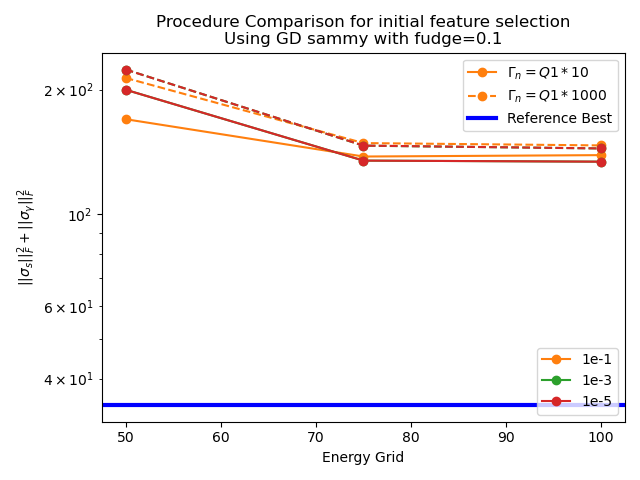

In [22]:

figure()

colors=["C1","C2","C3","C4", "C5"]
markers=['o-', 'o--']

for ig, gn in enumerate(["Gn10min", "Gn1000min"]):
# for gn in ["Gnmin"]:
    for i, ithresh in enumerate(["1en1", "1en3", "1en5"]):
        label = f"{gn}_{ithresh}"
        metric_v_iE = metrics[label]
        plot(iE, metric_v_iE, markers[ig], color = colors[i])

# reference_metric = Fnorms_reference["elastic"]**2 + Fnorms_reference["capture"]**2 
reference_metric = np.unique(metrics["refbest"].values)
axhline(reference_metric,  label="Reference Best", color='b', lw=3)

xlabel("Energy Grid")
title("Procedure Comparison for initial feature selection\nUsing GD sammy with fudge=0.1")
ylabel(r"$||\sigma_s||_F^2 + ||\sigma_{\gamma}||_F^2$")
yscale('log')


lines = gca().get_lines()
legend1 = legend([lines[i] for i in [0,3,6]], [r"$\Gamma_n=Q1*10$", r"$\Gamma_n=Q1*1000$", "Reference Best"], loc=1)
legend(["1e-1", "1e-3", "1e-5"], loc="lower right")
gca().add_artist(legend1)
tight_layout()

# for ig, gn in enumerate(["Gn10min", "Gn1000min"]):
#     for i, ithresh in enumerate(["1en2", "1en5"]):
#             label = f"{gn}_{ithresh}"
#             metric_v_iE = metrics[label]
#             plot(iE, metric_v_iE, label=label)
# legend()

In [13]:
20*500*5000

50000000

In [91]:

# figure()

# for rxn in reactions:
#     plot(x, [f[rxn] for f in fnorms_iE], '.-', label=rxn)

# plot(x, [f["all"] for f in fnorms_iE], '.-', label="all rxn")

# xlabel('iE')
# ylabel(r'$||R||_{F}$')
# title("Fnorm 500 samples; sammy GD feature selection\n <Gn>, <Gg>, elim Gn<1e-5 meV")
# legend()

In [87]:

# iE = 100
# true_par_list = []
# est_par_list = []
# Gn_list = []
# for isample in range(500):
#     true_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical

#     try:
#         csvfile = os.path.join(basepath, f"par_i{isample}_iE{iE}.csv")
#         par_df = pd.read_csv(csvfile)
#         est_par = par_df[["E", "Gg", "Gn1"]]
#         est_par = sammy_functions.fill_sammy_ladder(est_par, Ta_pair, J_ID=np.ones(len(est_par)))

#         true_par_list.append(true_par)
#         est_par_list.append(est_par)
#         Gn_list.extend(list(est_par.Gn1))
#     except:
#         pass

### individual case analysis

In [19]:
# abs(np.sum(Rdict['capture'], axis=1))

gn = "gn1000min"
thresh = "1en3"
iE = 75

path = "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/1spingroup"
Rdict = {}
Rdict["capture"] = np.load(os.path.join(path, f"res_cap_{gn}_{thresh}_iE{iE}.npy"))
Rdict["elastic"] = np.load(os.path.join(path, f"res_scat_{gn}_{thresh}_iE{iE}.npy"))


print(np.argmax(abs(np.sum(Rdict['capture'], axis=1))))#.shape
print(np.argmax(abs(np.sum(Rdict['elastic'], axis=1))))#.shape

453
296


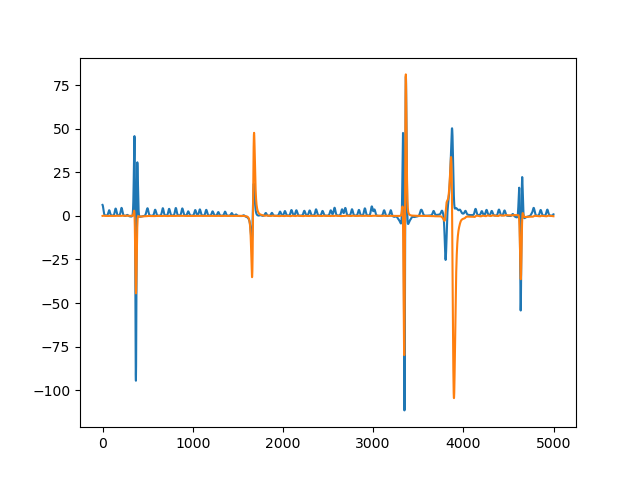

In [20]:
figure()
plot(Rdict["capture"][260, :])
plot(Rdict["elastic"][260, :])

In [22]:
### get estimate and true

isample = 453

dataset_titles = ["trans1", "cap1"]
datasets = []
for dt in dataset_titles:
    exp_pw, exp_cov = h5io.read_pw_exp(case_file, isample, title=dt)
    datasets.append(exp_pw)

trans = datasets[0]
cap = datasets[1]

true_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical

csvfile = os.path.join(path, f"{gn}", f"step2_{thresh}", f"par_i{isample}_iE{iE}.csv")
par_df = pd.read_csv(csvfile)
est_par = par_df[["E", "Gg", "Gn1"]]
est_par = sammy_functions.fill_sammy_ladder(est_par, Ta_pair, J_ID=np.ones(len(est_par)))

par_df

,Unnamed: 0,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID,time
0,0,199.794393,64.100845,0.123229,1.0,1.0,1.0,1.0,24.82342
1,1,200.622961,63.861685,0.099221,1.0,1.0,1.0,1.0,24.82342
2,2,201.207002,63.749742,0.082724,1.0,1.0,1.0,1.0,24.82342
3,3,202.055672,63.961576,0.062950,1.0,1.0,1.0,1.0,24.82342
4,4,202.476407,63.945584,0.043130,1.0,1.0,1.0,1.0,24.82342
...,...,...,...,...,...,...,...,...,...
70,70,247.534169,64.101573,0.171414,1.0,1.0,1.0,1.0,24.82342
71,71,247.887247,63.993918,0.196608,1.0,1.0,1.0,1.0,24.82342
72,72,248.748513,63.944439,0.174374,1.0,1.0,1.0,1.0,24.82342
73,73,249.496777,64.012826,0.166494,1.0,1.0,1.0,1.0,24.82342


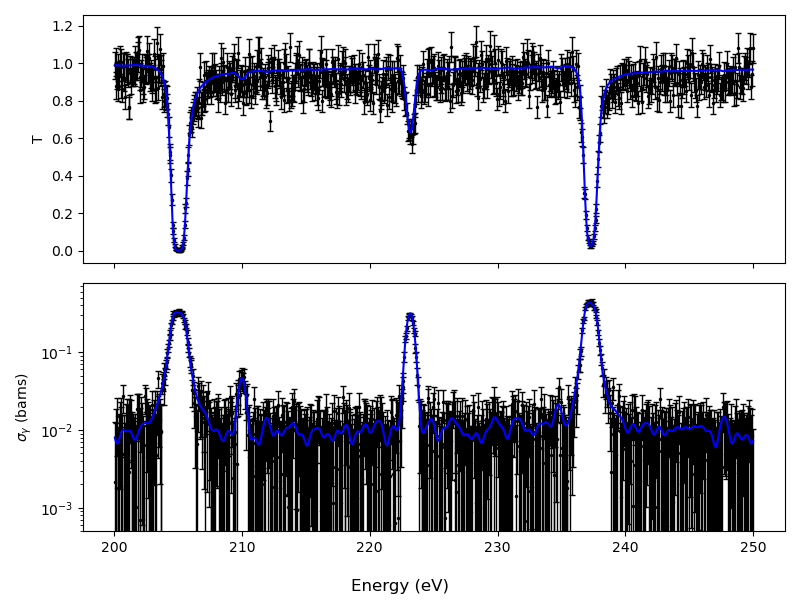

In [23]:
### plot experimental

sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'XCT',
    reaction = 'transmission',
    solve_bayes = False,
    inptemplate = "allexptot_1sg.inp",
    )

sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = par_df,
    energy_grid=exp_pw.E.values,
    temp = 304.5,
    FP=75.0,
    frac_res_FP=0.025,
    target_thickness=0.005)

sammyOUT_trans = sammy_functions.run_sammy(sammyINP, sammyRTO)

sammyRTO.reaction = 'capture'
sammyRTO.inptemplate = 'allexpcap_1sg.inp'
sammyOUT_cap = sammy_functions.run_sammy(sammyINP, sammyRTO)

fig = plot_trans_cap(trans, cap, T1=sammyOUT_trans.pw,C1=sammyOUT_cap.pw, plot_true=False)

capture
246959.30341545522
elastic
824044.2631097978


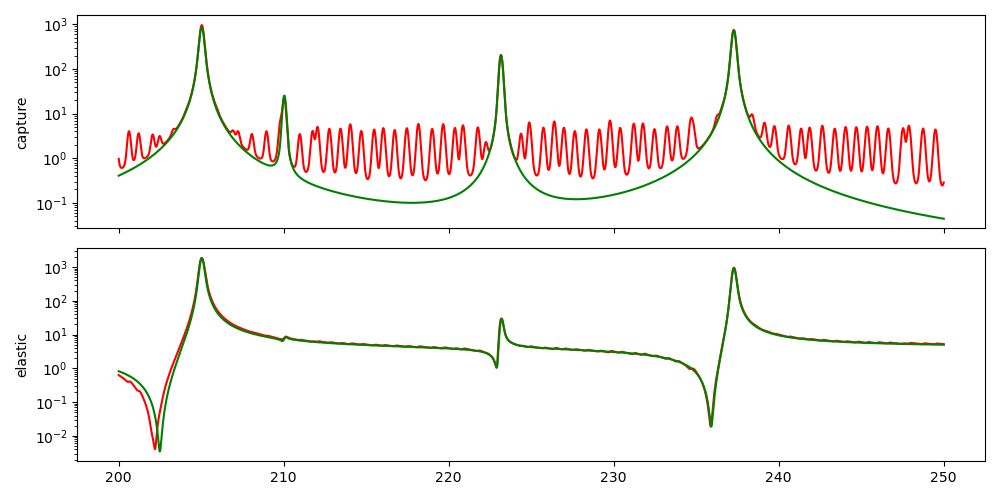

In [24]:

est_df, true_df = fnorm.get_rxns(true_par, est_par,
                            sammy_exe, shell,
                            Ta_pair, 
                            energy_range,
                            temperature, 
                            target_thickness,
                            template, reactions)
fig, axes = subplots(2,1, figsize=(10,5), sharex=True)

for i in range(2):
    axes[i].plot(est_df.E, est_df[reactions[-i]], 'r')
    
    print(reactions[-i])
    print(np.sum((est_df[reactions[-i]] - true_df[reactions[-i]])**2))
    axes[i].plot(true_df.E, true_df[reactions[-i]], 'g')

    axes[i].set_yscale('log')
    axes[i].set_ylabel(reactions[-i])

# axes[1].plot(cap.E, cap.exp,'k.')

fig.tight_layout()

capture
422706.3342659651
elastic
513817.15925673035


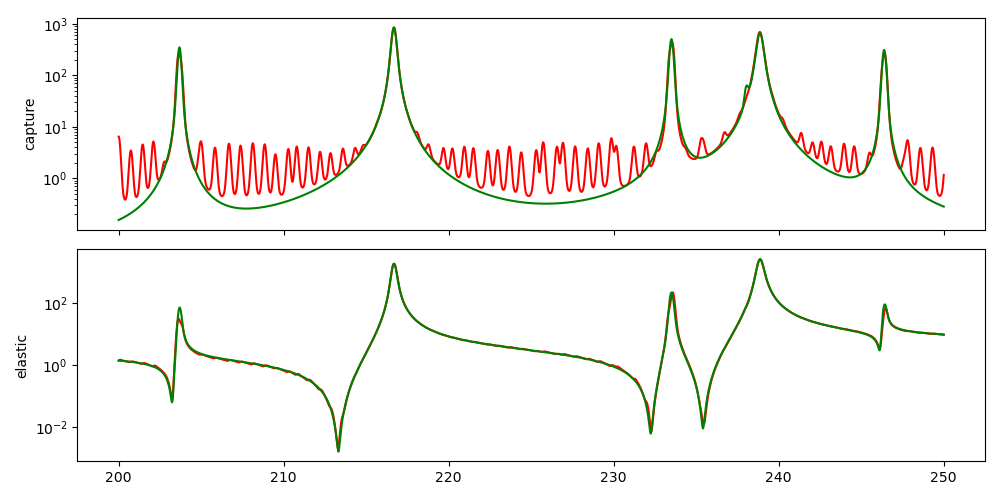

In [41]:
### Plot theoretical

est_df, true_df = fnorm.get_rxns(true_par, est_par,
                            sammy_exe, shell,
                            Ta_pair, 
                            energy_range,
                            temperature, 
                            target_thickness,
                            template, reactions)
fig, axes = subplots(2,1, figsize=(10,5), sharex=True)

for i in range(2):
    axes[i].plot(est_df.E, est_df[reactions[-i]], 'r')
    print(reactions[-i])
    print(np.sum((est_df[reactions[-i]] - true_df[reactions[-i]])**2))
    axes[i].plot(true_df.E, true_df[reactions[-i]], 'g')

    axes[i].set_yscale('log')
    axes[i].set_ylabel(reactions[-i])

# axes[1].plot(cap.E, cap.exp,'k.')

fig.tight_layout()

In [ ]:
# import imageio


# def make_fitgif(isample, iE):

#     with open(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/ifinal_nE{iE}.txt", 'r') as f:
#         lines = f.readlines()
#     for line in lines:
#         if line.startswith(f"{isample} "):
#             ifinals = line.split()
    
#     for istep in [1,2,3,4]:
#         folder = f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/sample_{isample}_iE{iE}_step{istep}"
#         for i in range(1,int(ifinals[istep])):
            
#             C1 = sammy_functions.readlst(os.path.join(folder,f"results/cap1_step{i}.lst"))
#             T1 = sammy_functions.readlst(os.path.join(folder,f"results/trans1_step{i}.lst"))
#             fig = plot_trans_cap(exp_pw, cap_pw, T1=T1, C1=C1)
#             fig.suptitle(f"Step: {istep}")

#             fig.savefig(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/figures/sample{isample}_iE{iE}_step{istep}_{i}.png")
#             close()
        
#     images = []
#     for istep in [1,2,3,4]:
#         for i in range(1,int(ifinals[istep])): #range(start_job,end_job):
#             images.append(imageio.imread(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/figures/sample{isample}_iE{iE}_step{istep}_{i}.png"))
#     imageio.mimsave(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/sample{isample}_iE{iE}.gif", images)

In [ ]:
# for istep in [1,2,3,4]:
#     fig = makefig()
#     fig.savefig(f"somewhere/sample{istep}.png")
#     close()
    
# images = []
# for istep in [1,2,3,4]:
#     images.append(imageio.imread(f"somewhere/sample{istep}.png"))
# imageio.mimsave(f"somewhere/my.gif", images)


/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_35036/1029206176.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/figures/sample{isample}_iE{iE}_step{istep}_{i}.png"))


In [19]:
# os.system(os.path.join(sammyRTO.sammy_runDIR, 'run.zsh'))
